# 1. 라이브러리 설정

In [1]:
# 기본 라이브러리
import numpy as np
import pandas as pd
import os
import warnings
import random

In [2]:
# 전처리 라이브러리
from sklearn.preprocessing import LabelEncoder

In [3]:
#시각화 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['font.family'] ='Malgun Gothic' #한글 깨짐 문제 방지
plt.rcParams['axes.unicode_minus'] =False

In [4]:
# 옵션 라이브러리
warnings.filterwarnings('ignore') # warinings 문구 생략 
pd.set_option('display.max_columns',30) # 열 30개 보여주기
pd.set_option('display.max_rows',30) #행 30개 보여주기

In [5]:
# 모델 라이브러리
from sklearn.model_selection import train_test_split # 데이터 분리
from sklearn.metrics import mean_squared_error #MSE
from sklearn.model_selection import StratifiedKFold # StratifiedKFold  과적합방지
from catboost import CatBoostClassifier, CatBoostRegressor # CatBoost

In [6]:
# Seed 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42)

In [7]:
# Optuna : 하이퍼파라미터 최적화 프레임워크
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

# 2. 데이터 불러오기

In [8]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')


#pd.set_option('display.max_rows', None) #모든 행을 보고자 할 때

- train.csv
    - PRODUCT_ID : 제품의 고유 ID
    - Y_Class : 제품 품질 상태(Target) 
        - 0 : 적정 기준 미달 (부적합)
        - 1 : 적합
        - 2 : 적정 기준 초과 (부적합)
    - Y_Quality : 제품 품질 관련 정량적 수치
    - TIMESTAMP : 제품이 공정에 들어간 시각
    - LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
    - PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)
    - X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수


- test.csv
    - PRODUCT_ID : 제품의 고유 ID
    - TIMESTAMP : 제품이 공정에 들어간 시각
    - LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
    - PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)
    - X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수


- sample_submission.csv
    - PRODUCT_ID : 제품의 고유 ID
    - Y_Class : 예측한 제품 품질 상태
        - 0 : 적정 기준 미달 (부적합)
        - 1 : 적합
        - 2 : 적정 기준 초과 (부적합)

# 3. EDA(탐색적 데이터 분석)

## 3.1 Data 형태 확인 

In [9]:
display(train, test, sub)

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,X_2861,X_2862,X_2863,X_2864,X_2865,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,197.286667,189.0,383.0,368.296296,353.0,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,193.296552,185.6,383.0,367.735849,353.0,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,179.820690,165.5,383.0,367.320755,353.0,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,181.920690,165.8,384.0,369.188679,353.0,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,196.393333,182.6,383.0,367.351852,352.0,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,TRAIN_593,1,0.526546,2022-09-08 14:30,T100306,T_31,2.0,95.0,0.0,45.0,10.0,0.0,50.0,10.0,52.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
594,TRAIN_594,0,0.524022,2022-09-08 22:38,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,180.810345,168.7,384.0,369.811321,353.0,49.47,53.07,50.89,55.10,66.49,1.0,NaN,NaN,NaN,NaN
595,TRAIN_595,0,0.521289,2022-09-08 22:47,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,176.486207,156.6,383.0,367.018868,352.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
596,TRAIN_596,1,0.531375,2022-09-08 14:38,T100304,O_31,40.0,94.0,0.0,45.0,11.0,0.0,45.0,10.0,31.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,PRODUCT_ID,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,...,X_2861,X_2862,X_2863,X_2864,X_2865,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TEST_000,2022-09-09 2:01,T100306,T_31,2.0,94.0,0.0,45.0,10.0,0.0,51.0,10.0,52.0,2.0,469.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TEST_001,2022-09-09 2:09,T100304,T_31,2.0,93.0,0.0,45.0,11.0,0.0,45.0,10.0,31.0,2.0,506.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TEST_002,2022-09-09 8:42,T100304,T_31,2.0,95.0,0.0,45.0,11.0,0.0,45.0,10.0,31.0,2.0,506.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TEST_003,2022-09-09 10:56,T010305,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,191.450000,183.8,467.0,444.192308,423.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TEST_004,2022-09-09 11:04,T010306,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,193.082143,179.7,465.0,443.211539,423.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,TEST_305,2022-11-05 11:18,T100306,T_31,2.0,91.0,0.0,45.0,10.0,0.0,51.0,10.0,52.0,2.0,502.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306,TEST_306,2022-11-05 16:39,T100304,T_31,2.0,96.0,0.0,45.0,11.0,0.0,45.0,10.0,31.0,2.0,513.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307,TEST_307,2022-11-05 16:47,T100306,T_31,2.0,91.0,0.0,45.0,10.0,0.0,50.0,10.0,52.0,2.0,502.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
308,TEST_308,2022-11-05 20:53,T100306,T_31,2.0,95.0,0.0,45.0,10.0,0.0,51.0,10.0,52.0,2.0,503.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,PRODUCT_ID,Y_Class
0,TEST_000,0
1,TEST_001,0
2,TEST_002,0
3,TEST_003,0
4,TEST_004,0
...,...,...
305,TEST_305,0
306,TEST_306,0
307,TEST_307,0
308,TEST_308,0


In [10]:
set(train.columns).difference(set(test.columns)) # train과 test 데이터 칼럼 비교

{'Y_Class', 'Y_Quality'}

Y_Class, Y_Quality를 제외한 나머지 컬럼은 train, test 모두 동일하다는 것을 알 수 있음.

In [11]:
set(sub['Y_Class']) # 예측한 제품 품질 상태

{0}

sub_Y_Class를 구하여 제품 품질 상태를 판단한다.

In [12]:
train.iloc[:,:10].info() #피쳐의 데이터 타입 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 598 entries, 0 to 597
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PRODUCT_ID    598 non-null    object 
 1   Y_Class       598 non-null    int64  
 2   Y_Quality     598 non-null    float64
 3   TIMESTAMP     598 non-null    object 
 4   LINE          598 non-null    object 
 5   PRODUCT_CODE  598 non-null    object 
 6   X_1           349 non-null    float64
 7   X_2           349 non-null    float64
 8   X_3           349 non-null    float64
 9   X_4           349 non-null    float64
dtypes: float64(5), int64(1), object(4)
memory usage: 46.8+ KB


## 3.2 Y_Class (제품 품질 상태(Target)) 분포

Text(0.5, 1.0, '제품 품질 상태(Target) 1:적합 0,2:부적합')

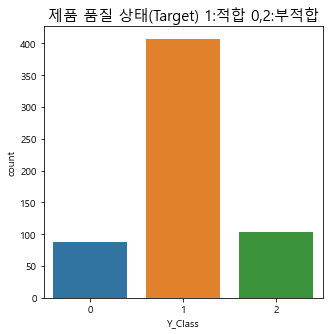

In [13]:
plt.figure(figsize=(5,5))
sns.countplot(x='Y_Class',data=train)
plt.xlabel('Y_Class',fontsize=10)
plt.title('제품 품질 상태(Target) 1:적합 0,2:부적합',fontsize=15)

In [14]:
train['Y_Class'].value_counts() # 제품 품질 상태 분포 확인

1    407
2    103
0     88
Name: Y_Class, dtype: int64

- 1(정상) : 407개
- 2(비정상) : 103개
- 3(비정상) : 88개
- 정상 Class가 많지만 Class가 약간의 불균형이 존재함.

## 3.3 Y_Quality(제품 품질 관련 정량적 수치) 분포 

Text(0.5, 1.0, '제품 품질 관련 정량적 수치')

<Figure size 360x360 with 0 Axes>

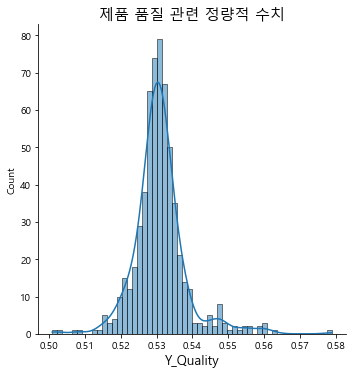

In [15]:
plt.figure(figsize=(5,5))
sns.displot(data=train,x='Y_Quality',kde=True)
plt.xlabel('Y_Quality',fontsize=13)
plt.title('제품 품질 관련 정량적 수치',fontsize=15)

0.5~0.58 사이의서 분포를 보이며, 약0.53에서 높은 분포를 가지는 정규분포의 형태가 나타남.

In [16]:
train.groupby(['Y_Class'])['Y_Quality'].describe() # Y_Class별 Y_Quality 중심화 경향 기초통계량 확인

,count,mean,std,min,25%,50%,75%,max
Y_Class,,,,,,,,
0,88.0,0.520837,0.004603,0.500856,0.519440,0.522054,0.524113,0.525067
1,407.0,0.530253,0.002444,0.525086,0.528378,0.530308,0.532129,0.534843
2,103.0,0.542031,0.008038,0.534951,0.536354,0.538508,0.546555,0.578841


각 Y_Class마다 Y_Quality의 Spec이 다르게 형성됨.
- Class 0 : (0.500856, 0.525067)
- Class 1 : (0.525086, 0.534843)
- Class 2 : (0.534951, 0.578841)

In [17]:
train['TIMESTAMP']

0       2022-06-13 5:14
1       2022-06-13 5:22
2       2022-06-13 5:30
3       2022-06-13 5:39
4       2022-06-13 5:47
             ...       
593    2022-09-08 14:30
594    2022-09-08 22:38
595    2022-09-08 22:47
596    2022-09-08 14:38
597    2022-09-08 14:46
Name: TIMESTAMP, Length: 598, dtype: object

In [18]:
train['TIMESTAMP'] = pd.to_datetime(train['TIMESTAMP'])
train['TIMESTAMP']

0     2022-06-13 05:14:00
1     2022-06-13 05:22:00
2     2022-06-13 05:30:00
3     2022-06-13 05:39:00
4     2022-06-13 05:47:00
              ...        
593   2022-09-08 14:30:00
594   2022-09-08 22:38:00
595   2022-09-08 22:47:00
596   2022-09-08 14:38:00
597   2022-09-08 14:46:00
Name: TIMESTAMP, Length: 598, dtype: datetime64[ns]

In [19]:
train['TIME'] = train['TIMESTAMP'].dt.month*60*24*30+train['TIMESTAMP'].dt.day*60*24+train['TIMESTAMP'].dt.hour*60+train['TIMESTAMP'].dt.minute
train['TIME']

0      278234
1      278242
2      278250
3      278259
4      278267
        ...  
593    401190
594    401678
595    401687
596    401198
597    401206
Name: TIME, Length: 598, dtype: int64

In [20]:
train['LINE_first'] = train['LINE'].str[1:3]
train['LINE_first']

0      05
1      05
2      05
3      05
4      05
       ..
593    10
594    05
595    05
596    10
597    10
Name: LINE_first, Length: 598, dtype: object